# MP 5: Learning to Predict Grasps

**Due date**: April 20, 2022 at 9:45am.

**Instructions**: Read and complete the problems below. In this assignment, you should be switched over to a local install. 

For problem 2 and 3, you will need to install PyTorch on your system, or use the Binder environment.  It is also possible to use Google Colab if you want to use a GPU for training.  To do so, try `pip install torch`. If you have trouble with the install, try `pip install torch==1.8.0+cpu` for a CPU-only install.

To submit your assignment, perform the following:

1. Double-check that your programs run without error.
2. Submit this file, all of your .py files, and some illustrative predicted images (just the ones referenced in your written answers) on Moodle [http:/learn.illinois.edu](http:/learn.illinois.edu).  DO NOT UPLOAD YOUR DATASETS OR MODELS!
3. If you are using any external libraries other than the ones that are indicated during the installation process, include a README file indicating which library and version you are using.  To be on the safe side, you should include a backup procedure until the graders verify that they are able to support use of that library.

## Dataset generation

We're going to generate lots of example RGB-D images paired with grasps from a "ground truth" dataset.  We will be using the grasps in the dataset `data/grasps/robotiq_85_sampled_grasps.json` and a couple candidate base worlds (table and shelf).  First, we will generate world models by sampling object placements at random, then generating simulated RGB-D images, and finally generate grasp attribute images which we will later attempt to predict in Problem 2.

`python generate_dataset.py worlds` implements a world sampler.  It will sample several placed objects in stable collision free poses, and save the worlds to `generated_worlds/world_XXXX.xml`. 

To visualize the worlds you've generated, run `klampt_browser generated_worlds/world_XXXX.xml`, or just run `klampt_browser` and click on each world file.  Note that you will need to run the program from the MP5 directory for the paths to be loaded properly.

![Example output](example_output/world_generation.png)

Next, `python generate_dataset.py images` will generate camera images from a simulated camera, as well as the associated grasp predictions.  The basic implementation generates 10 randomized object and table colors per scene, and will use a standard grasp library for each object as well as collision checking with the gripper to generate the "ground truth".

The result should be a set of files looking like this giving the simulated RGBD images:

![Example output](example_output/color_0000_var0000.png)
![Example output](example_output/depth_0000_var0000.png)

And a set of  "ground truth" labels for generating grasp attribute maps (images that give the per-pixel grasp attribute).  There are four attributes that we will predict:
- Grasp score (as predefined in the Grasp datastructure)
- Opening width
- Jaw opening axis, heading in camera frame
- Jaw opening axis, elevation in camera frame 

Note that since the axis is symmetric, we use the convention that the heading goes from 0 to 180 degrees, and the elevation goes from -90 to 90 degrees corresponding to a heading with y positive. The generator takes the sampled grasps and constructs a grasp attribute map, and rather than projecting a single grasp point to a pixel, it spreads out the attributes of sampled grasps to neighboring pixels so that similar scores are predicted at nearby points.

![Example output](example_output/grasp_0000_score.png)
![Example output](example_output/grasp_0000_opening.png)
![Example output](example_output/grasp_0000_axis_theta.png)
![Example output](example_output/grasp_0000_axis_elevation.png)



## Problem 1: Feature Generation and Machine Learning

In `problem2.py`, you will perform learning with the generated dataset using [Scikit-learn](https://scikit-learn.org/stable/).  This is a popular machine learning package which is quite easy to use.  (It is possible also to use PyTorch or TensorFlow for deep learning, but these often involve complex installation steps.)

The student who produces the most sensible predictions will be given extra credit!

### Problem 1.A

In `dataset.py`'s `make_patch_dataset` function, you will extract some number of example points from the image dataset to use for learning. Each example point will consist of a feature vector $x_i$ and a target value $y_i$, and we will predict $y=f(x)$.  You will need to settle upon a *feature representation*; that is, a method to extract a vector representation $x(color,depth,camera_xform,pixel)$ of the image characteristics affecting the label $y$ of the given pixel. 

The current implementation just selects 100 pixels at random and then returns a patch of the color and depth images around each sampled pixel.  There are two issues with this method:

- This has a high likelihood of oversampling low-quality regions and undersampling high quality grasps.
- Using raw depth and color might bias the predictor to use 

You should balance the sampling to include more pixels with higher quality grasps, and play around with what features you decide to include in your dataset.  You might also tune the patch size.

### Problem 1.B

Now that we've constructed a dataset, it's time to run some learning algorithms.  Implement some learning technique in `learn_classical.py`'s `train_predictor`.  By default, we include a simple pipeline that first performs Principal Components Analysis (PCA) to reduce the dimension of your image patch to a much smaller vector, then performs a linear regression.  You can try this using `python learn_classical.py train`. A few other possible pipelines are commented out.

Along with your feature selection explorations in Problem 1.A, choose a learning technique that produces relatively low testing error in comparison to predicting the average value.  Understanding these models and their hyperparameters may require investigating the documentation of Scikit-learn.  Also, you can use a [model selection technique](https://scikit-learn.org/stable/modules/grid_search.html) to help you select good model hyperparameters.

In your written answers below, describe how  you balanced sampling, what features you included in your dataset, and what ultimate model you used.  How well does that model compare against predicting the average, and against plain PCA + linear regression?


### Problem 1.C

Now, you will try using your model and feature extraction model to predict the score over a whole image.  Implement `learn_classical.py`'s `predict_patches` to predict the score for all the pixels in `pts` using your existing model. Keep in mind that you will need to extract exactly the same features!

Note that `python learn_classical.py test` will run very, very slowly since it's running on every pixel.  Wait for one image to be output to the `predictions` folder and include it in your written answers below.

![Example output](example_output/image_0000.png)


## Problem 2: Deep Learning for Image-Based Prediction

Next, you will learn image-based grasp prediction as in Problem 1, but you'll be using [PyTorch](https://scikit-learn.org/stable/) instead.  This is one of the most pleasant-to-use deep learning toolkits out there, and with a bit of scaffolding code it should work like magic.  (That's not to say that For most of you, you can install it on your local machine using `pip install torch`. You may also be able to use `pip install torch==1.8.0+cpu` if you find that the normal installation fails -- this will just use the CPU for training.  This is not a big deal; our problems are not ridiculously big and you might end up using the CPU to train anyways.  If all else fails, you can boot this notebook up on Binder or even try some GPU-based machines on Google Colab.



### Problem 2.A

In `dataset_pytorch.py`, `make_patch_dataset` will extract some number of example patches from the image dataset to use for learning.   Run this once to create a dataset of small images in the `patches` folder.

In this learning task, each example point will consist of a feature tensor $x_i$ and a target value $y_i$, and we will predict $y=f(x)$.  We'll just use the concatenation of the color and depth image patches as the feature tensor, which will be a 3D array of size 4 x patch_size x patch_size (the first index indicates R, G, B, and depth channels).  The target value will be a 4-D vector consisting of the score, width, heading, and elevation.  The train and test datasets will be drawn randomly from the patches.  The simple model provided for you will use a linear model followed by a rectified linear unit (ReLU).

Next, you will create a convolutional neural network to predict the output.   Create a convolutional neural network that uses two layers of:
- [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), ReLU, and [max-pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

For the Conv2D layers, start by using a 3x3 convolution, 16 output channels, stride=1, and padding=1. Use 2x2 max-pooling.

Follow up the convolutional layers using a fully-connected network consisting of one hidden layer that performs:
- flattening,
- linear layer, output size 30,
- ReLU,
- another linear layer, output size 4

Train your model using the `train` function given above.  Compare the training process time, training curves, and ultimate RMSE on predicting the score attribute.  Place your response in the area for written answers below.


In [19]:
#load some basic utility code

%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import math
import time
import random

class Flatten(nn.Module):
  """Utility NN Module that flattens the incoming tensor."""
  def forward(self, input):
    return input.view(input.size(0), -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Generates patches
import dataset_pytorch

dataset_pytorch.generate_patch_dataset()

Read 100 training images
Saved samples to patch_dataset/


Read 100 training images


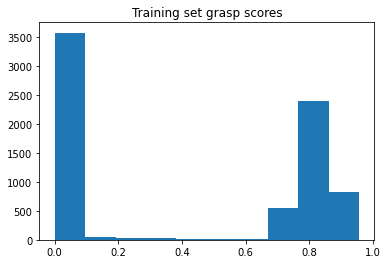

In [21]:
#Loads the patches and displays the distribution of grasp scores
%matplotlib inline
import matplotlib.pyplot as plt
import dataset_pytorch

from torchvision import transforms
import torchvision.transforms.functional as TF

#If you want to experiment with color vs depth, you can try changing this to True...
#(Note that your networks will need to support 1 channel rather than 4 if the flag is set!)
DEPTH_ONLY = False

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class AddGaussianOffset(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        offset = random.gauss(self.mean,self.std)
        return tensor + torch.ones(tensor.size())*offset
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ToTorchDataset:
    """a little shim code to pack the depth channel onto the color image and
    switch around the color channel order"""
    def __init__(self,patch_dataset):
        self.patch_dataset = patch_dataset
        #TODO: problem 2B: create a Transform object here to do data augmentation
        self.color_transform = transforms.ColorJitter(0.2,0.2,0.5,0.5)
        self.depth_transform = AddGaussianOffset(0,0.2)
        # self.color_transform = None 
        # self.depth_transform = None
    def __len__(self):
        return len(self.patch_dataset)
    def __getitem__(self,idx):
        res = self.patch_dataset[idx]
        color = res['color']
        depth = res['depth']
        output = res['output']
        color = TF.to_tensor(color)
        depth = torch.from_numpy(depth[np.newaxis,:,:].astype(np.float32))
        if self.color_transform is not None:
            color = self.color_transform(TF.to_pil_image(color))
            color = TF.to_tensor(color)
        if self.depth_transform is not None:
            depth = self.depth_transform(depth)
        if DEPTH_ONLY:
            packed_image = depth
        else:
            packed_image = torch.cat((color,depth))
        return packed_image,output.astype(np.float32)

#sanity check
def plot_scores(dataset,title):
    data = []
    for input,output in dataset:
        data.append(output[0])
    plt.hist(data)
    plt.title(title)
    plt.show()

training_set = ToTorchDataset(dataset_pytorch.PatchDataset('image_dataset','patch_dataset/train.csv'))
testing_set = ToTorchDataset(dataset_pytorch.PatchDataset(training_set.patch_dataset.dataset,'patch_dataset/test.csv'))
testing_set.color_transform = None
testing_set.depth_transform = None
plot_scores(training_set,'Training set grasp scores')



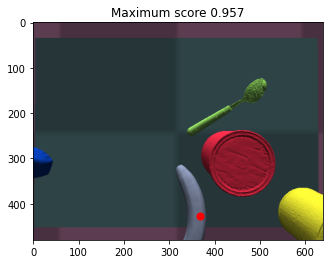

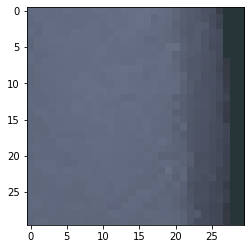

In [22]:
#Show the best patch, for a sanity check
best = training_set.patch_dataset.best_patch
score,img,x,y,color_patch,depth_patch = best
plt.title("Maximum score %.3f"%score)
plt.imshow(training_set.patch_dataset.dataset[img][0])
plt.scatter(x, y, s=50, c='red', marker='o')
plt.show()
plt.imshow(color_patch)
plt.show()

In [23]:
import torch.cuda as cuda

CUDA = cuda.is_available()
# CUDA = False
SEED = 1
BATCH_SIZE = 8
PATCH_SIZE = training_set.patch_dataset.patch_size

# Use a GPU, i.e. cuda:0 device if it available.
if CUDA:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device",device)

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

train_loader = torch.utils.data.DataLoader(training_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)
test_loader = torch.utils.data.DataLoader(testing_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)


Using device cuda:0


In [24]:
#Scrap code to get a better sense of what the DataLoader does...
for batch in train_loader:
    input,output = batch
    print(input.__class__.__name__)  #Oh look, it's returning a Tensor
    print(input.size(),output.size())  #The leading dimension is 8!  That's the batch size.
    print(output)  #this is the 4-D output for 8 examples
    break

Tensor
torch.Size([8, 4, 30, 30]) torch.Size([8, 4])
tensor([[0.7882, 0.5412, 0.9059, 0.5176],
        [0.0000, 0.0000, 0.0000, 0.4980],
        [0.8549, 0.2784, 0.4353, 0.5020],
        [0.0000, 0.0000, 0.0000, 0.4980],
        [0.8510, 0.3333, 0.5725, 0.5216],
        [0.0000, 0.0000, 0.0000, 0.4980],
        [0.9255, 0.5922, 0.2314, 0.5216],
        [0.7882, 0.6431, 0.0941, 0.4980]])


In [25]:
#generic training code
def train(model, train_loader, test_loader, loss_func, opt, num_epochs=10, calc_rmse=True):
  all_training_loss = np.zeros((0,2))
  all_training_score_rmse = np.zeros((0,2))
  all_test_loss = np.zeros((0,2))
  all_test_score_rmse = np.zeros((0,2))
  
  training_step = 0
  training_loss, training_score_rmse = 0.0, 0.0
  print_every = 250
  
  start = time.time()
  
  for i in range(num_epochs):
    epoch_start = time.time() 
   
    model.train()
    for images,labels in train_loader:
      cpu_labels = labels
      images, labels = images.to(device), labels.to(device)
      opt.zero_grad()

      preds = model(images)
      loss = loss_func(preds, labels)
      loss.backward()
      opt.step()
      
      training_loss += loss.item()
      if calc_rmse:
          training_score_rmse += np.sum((preds.detach().cpu().numpy()[:,0]-cpu_labels.numpy()[:,0])**2)
      
      if training_step % print_every == 0:
        training_loss /= print_every
        training_score_rmse = math.sqrt(training_score_rmse / (print_every*BATCH_SIZE))
        
        if CUDA:
          all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
          all_training_score_rmse = np.concatenate((all_training_score_rmse, [[training_step, training_score_rmse]]))
        else:
          all_training_loss = np.concatenate((all_training_loss, [[training_step, training_loss]]))
          all_training_score_rmse = np.concatenate((all_training_score_rmse, [[training_step, training_score_rmse]]))
                  
        print('Epoch %d step %d: Train Loss: %3f, Score RMSE: %3f' % (
            i, training_step, training_loss, training_score_rmse))
        training_loss, training_score_rmse = 0.0, 0.0
        
      training_step+=1

    model.eval()
    with torch.no_grad():
      validation_loss, validation_score_rmse = 0.0, 0.0
      count = 0
      for images,labels in test_loader:
        cpu_labels = labels
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        validation_loss+=loss_func(output,labels)
        if calc_rmse:
            validation_score_rmse+=np.sum((output.detach().cpu().numpy()[:,0]-cpu_labels.numpy()[:,0])**2)
        count += 1
      validation_loss /= count
      validation_score_rmse = math.sqrt(validation_score_rmse/(count*BATCH_SIZE))
      
      if CUDA:
        all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss.cpu()]]))
        all_test_score_rmse = np.concatenate((all_test_score_rmse, [[training_step, validation_score_rmse]]))
      else:
        all_test_loss = np.concatenate((all_test_loss, [[training_step, validation_loss]]))
        all_test_score_rmse = np.concatenate((all_test_score_rmse, [[training_step, validation_score_rmse]]))
      
      epoch_time = time.time() - epoch_start
      
      print('Epoch %d: Test Loss: %3f, Score RMSE: %3f, time: %.1fs' % (
          i, validation_loss, validation_score_rmse, epoch_time))
      
  total_time = time.time() - start
  print('Final Test Loss: %3f, Test RMSE: %3f, Total time: %.1fs' % (
      validation_loss, validation_score_rmse, total_time))

  return {'loss': { 'train': all_training_loss, 'test': all_test_loss },
          'score RMSE': { 'train': all_training_score_rmse, 'test': all_test_score_rmse }}

def plot_graphs(model_name, metrics):
  for metric, values in metrics.items():
    for name, v in values.items():
      plt.plot(v[:,0], v[:,1], label=name)
    plt.title(f'{metric} for {model_name}')
    plt.legend()
    plt.xlabel("Training Steps")
    plt.ylabel(metric)
    plt.show()
    

Epoch 0 step 0: Train Loss: 0.001113, Score RMSE: 0.027140
Epoch 0 step 250: Train Loss: 0.931003, Score RMSE: 0.905963
Epoch 0 step 500: Train Loss: 0.114867, Score RMSE: 0.386862
Epoch 0 step 750: Train Loss: 0.090200, Score RMSE: 0.366300
Epoch 0: Test Loss: 0.313708, Score RMSE: 0.393186, time: 3.3s
Epoch 1 step 1000: Train Loss: 0.085895, Score RMSE: 0.376126
Epoch 1 step 1250: Train Loss: 0.075463, Score RMSE: 0.360836
Epoch 1 step 1500: Train Loss: 0.083475, Score RMSE: 0.371293
Epoch 1 step 1750: Train Loss: 0.072537, Score RMSE: 0.356887
Epoch 1: Test Loss: 0.074780, Score RMSE: 0.361363, time: 3.3s
Epoch 2 step 2000: Train Loss: 0.076455, Score RMSE: 0.366696
Epoch 2 step 2250: Train Loss: 0.072600, Score RMSE: 0.360385
Epoch 2 step 2500: Train Loss: 0.071399, Score RMSE: 0.359491
Epoch 2 step 2750: Train Loss: 0.071410, Score RMSE: 0.357560
Epoch 2: Test Loss: 0.071691, Score RMSE: 0.356149, time: 3.3s
Epoch 3 step 3000: Train Loss: 0.071217, Score RMSE: 0.357534
Epoch 3 ste

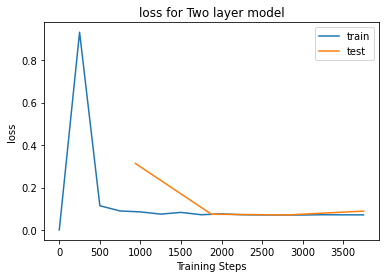

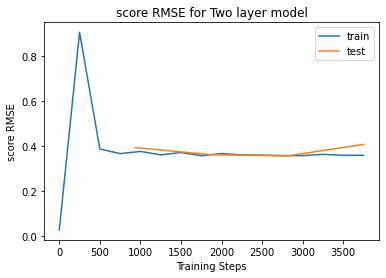

In [26]:
# Train a simple two-layer fully connected model
class TwoLayerModel(nn.Module):
  def __init__(self):
    super(TwoLayerModel, self).__init__()
    channels = 1 if DEPTH_ONLY else 4
    self.net = nn.Sequential(
      Flatten(), 
      nn.Linear(PATCH_SIZE*PATCH_SIZE*channels, 64),
      nn.ReLU(), 
      nn.Linear(64, 4))
    
  def forward(self, x):
    return self.net(x)

model_2layer = TwoLayerModel().to(device)

# Configure the training
loss = nn.MSELoss()
optimizer = optim.RMSprop(model_2layer.parameters(), lr=0.001, weight_decay=0.01)
training_epochs=4  #this is a simple model, so training will converge in only 3-4 epochs
metrics = train(model_2layer, train_loader, test_loader, loss, optimizer, training_epochs)
torch.save(model_2layer.state_dict(), "model_2layer.pkl")  #save to disk
plot_graphs("Two layer model",metrics)

#to load a prior model, run this code rather than optimizing
#model_2layer.load_state_dict(torch.load("model_2layer.pkl"))

Epoch 0 step 0: Train Loss: 0.001006, Score RMSE: 0.039716
Epoch 0 step 250: Train Loss: 0.086485, Score RMSE: 0.380234
Epoch 0 step 500: Train Loss: 0.069177, Score RMSE: 0.346391
Epoch 0 step 750: Train Loss: 0.069089, Score RMSE: 0.350041
Epoch 0: Test Loss: 0.064405, Score RMSE: 0.334335, time: 3.3s
Epoch 1 step 1000: Train Loss: 0.070368, Score RMSE: 0.353756
Epoch 1 step 1250: Train Loss: 0.069819, Score RMSE: 0.351612
Epoch 1 step 1500: Train Loss: 0.065456, Score RMSE: 0.339054
Epoch 1 step 1750: Train Loss: 0.064908, Score RMSE: 0.341500
Epoch 1: Test Loss: 0.063963, Score RMSE: 0.333598, time: 3.3s
Epoch 2 step 2000: Train Loss: 0.068576, Score RMSE: 0.346108
Epoch 2 step 2250: Train Loss: 0.065615, Score RMSE: 0.341125
Epoch 2 step 2500: Train Loss: 0.067837, Score RMSE: 0.349364
Epoch 2 step 2750: Train Loss: 0.064558, Score RMSE: 0.337912
Epoch 2: Test Loss: 0.063093, Score RMSE: 0.328186, time: 3.3s
Epoch 3 step 3000: Train Loss: 0.068222, Score RMSE: 0.343524
Epoch 3 ste

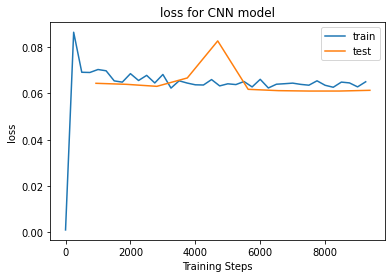

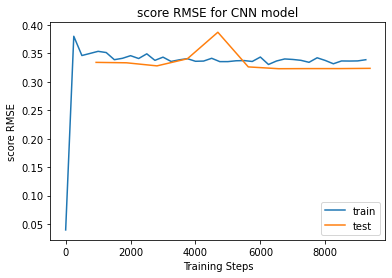

In [27]:

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        channels = 1 if DEPTH_ONLY else 4
        #TODO: create your model
        self.net = nn.Sequential(
             nn.Conv2d(in_channels=channels, out_channels=16,kernel_size=(3,3),stride=1,padding=1),
             nn.ReLU(),
             nn.MaxPool2d((2,2)),
             Flatten(),
             nn.Linear(channels*PATCH_SIZE*PATCH_SIZE, 30),
             nn.ReLU(),
             nn.Linear(30,4)
        )
    
    def forward(self, x):
        return self.net(x)

training_epochs = 10
loss = nn.MSELoss()
model_cnn = CNNModel().to(device)
optimizer = optim.RMSprop(model_cnn.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(model_cnn, train_loader, test_loader, loss, optimizer, training_epochs)
torch.save(model_cnn.state_dict(), "model_cnn.pkl")  #save to disk
plot_graphs("CNN model",metrics)

#to load a prior model, run this code rather than optimizing
#model_cnn.load_state_dict(torch.load("model_cnn.pkl"))


### Problem 2.B

Now, go back to `make_patch_dataset` and the `ToTorchDataset` class in the cell above to improve the output.  As in Problem 1.A, the basic function has a high likelihood of oversampling low-quality regions and undersampling high quality grasps.  First, you should modify `dataset_pytorch.py` to balance the patch dataset to include more pixels with higher quality grasps.

Next, implement data augmentation to ensure that the learner ignores certain characteristics of the images when making its predictions.  This is done using a Transform object from PyTorch, and is described in more detail in the [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).  You can use the torchvision [ColorJitter](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter) function to modify color.  The absolute depth also shouldn't affect the prediction much, so you can get better generalization by adding jitter to the depth channel (such as the `AddGaussianOffset` modifier).  But don't go crazy adding huge offsets, because the depth changes the size of objects relative to the gripper width.

Report the changes that you get in the training/testing accuracy in the area for written answers below.

The code below does grasp attribute prediction for all pixels one of your test images. Let it run once, and keep the output in your submitted notebook.


In [28]:
#This creates one prediction image for your CNN model
#images = training_set.patch_dataset.dataset
images = testing_set.patch_dataset.dataset
color,depth,transform,grasp_attrs = images[0]
patch_radius = training_set.patch_dataset.patch_size//2
grasp_preds = np.zeros((480,640,4))
for y in range(color.shape[0]):
    if y%5 == 0:
        print("Working on row",y)
    all_patches = []
    for x in range(color.shape[1]):
        roi = (y-patch_radius,y+patch_radius,x-patch_radius,x+patch_radius)
        patch1 = dataset_pytorch.get_region_of_interest(color,roi)
        patch2 = dataset_pytorch.get_region_of_interest(depth,roi)
        if DEPTH_ONLY:
            image_packed = patch2[np.newaxis,:,:].astype(np.float32)
        else:
            image_packed = np.append(np.transpose(patch1,(2,0,1)),patch2[np.newaxis,:,:],0).astype(np.float32)
        all_patches.append(image_packed)
    model_cnn.eval()
    with torch.no_grad():
        all_predictions = model_cnn.forward(torch.from_numpy(np.array(all_patches)).to(device)).cpu()
    grasp_preds[y] = all_predictions.numpy().reshape((640,4))


Working on row 0
Working on row 5
Working on row 10
Working on row 15
Working on row 20
Working on row 25
Working on row 30
Working on row 35
Working on row 40
Working on row 45
Working on row 50
Working on row 55
Working on row 60
Working on row 65
Working on row 70
Working on row 75
Working on row 80
Working on row 85
Working on row 90
Working on row 95
Working on row 100
Working on row 105
Working on row 110
Working on row 115
Working on row 120
Working on row 125
Working on row 130
Working on row 135
Working on row 140
Working on row 145
Working on row 150
Working on row 155
Working on row 160
Working on row 165
Working on row 170
Working on row 175
Working on row 180
Working on row 185
Working on row 190
Working on row 195
Working on row 200
Working on row 205
Working on row 210
Working on row 215
Working on row 220
Working on row 225
Working on row 230
Working on row 235
Working on row 240
Working on row 245
Working on row 250
Working on row 255
Working on row 260
Working on row 

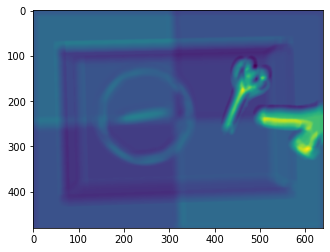

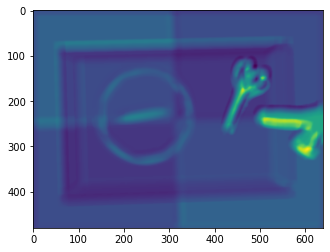

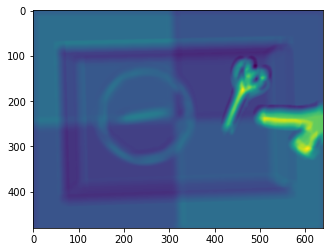

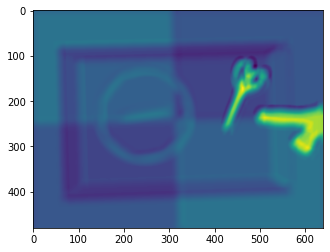

In [29]:
#Show each of your predictions
plt.imshow(grasp_preds[:,:,0])
plt.show()
plt.imshow(grasp_preds[:,:,1])
plt.show()
plt.imshow(grasp_preds[:,:,2])
plt.show()
plt.imshow(grasp_preds[:,:,3])
plt.show()

## Problem 3: Whole-image prediction (4-credit section only)

Now that you've gotten the hang of writing networks, we'll try to predict the score over a whole image.  We don't want to use the same patch extraction pipeline as before on a per-pixel basis, since it's expensive and will take minutes.  Instead, we'll use a method similar to the popular U-net architecture for image segmentation.

The idea is that there will be three steps of convolution with downsampling; the resulting 8x downsampled image is assumed to have absorbed enough information from a patch of neighboring pixels to be treated like a feature.  The coarsest level of features will then be
- [upsampled](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) by 2x
- [concatenated](https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat) with the 4x downsampled image.
- Passed through a convolutional layer
- Finally, followed by a ReLU (no max-pooling). 

The result of this level is then treated as the features at the second coarsest level; repeating this process again will give you features for the second finest level, and then repeating a final time will give you features for the output level.

The example code below does this for a single stages of paired downsampling / upsampling layers.  Repeat this to complete 3 or more stages. Note that the work needs to be done within the `forward` call, and isn't as simple as calling a Sequence.  Furthermore, for PyTorch to automatically discover the parameters of your network, each module that you use should be an attribute of `self`.

Run the subsequent cell to show your predictions.  You may try to improve your results.  If so, what did you try to improve them, and if not, what do you think you could do to improve them?  Give your answers in the spaces for written answers below.

In [30]:
class WholeImageDataset:
    def __init__(self,folder,split_start=0,split_end=0.75):
        self.dataset = dataset_pytorch.load_images_dataset(folder)
        N = len(self.dataset)
        self.dataset = self.dataset[int(N*split_start):int(N*split_end)]
        self.color_transform = None
        self.depth_transform = None
        self.color_transform = transforms.ColorJitter(0.2,0.2,0.5,0.5)
        self.depth_transform = AddGaussianOffset(0,0.2)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        color,depth,transform,grasp_attrs = self.dataset[idx]
        color = TF.to_tensor(color)
        depth = torch.from_numpy(depth[np.newaxis,:,:].astype(np.float32))
        if self.color_transform is not None:
            color = self.color_transform(TF.to_pil_image(color))
            color = TF.to_tensor(color)
        if self.depth_transform is not None:
            depth = self.depth_transform(depth)
        if DEPTH_ONLY:
            packed_image = depth
        else:
            packed_image = torch.cat((color,depth))
        return packed_image,np.array([grasp_attrs[v] for v in ['score','opening','axis_heading','axis_elevation']],dtype=np.float32)

whole_image_training_set = WholeImageDataset('image_dataset',0,0.75)
whole_image_testing_set = WholeImageDataset('image_dataset',0.75,1)
whole_image_testing_set.color_transform = None
whole_image_testing_set.depth_transform = None
whole_image_train_loader = torch.utils.data.DataLoader(whole_image_training_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)
whole_image_test_loader = torch.utils.data.DataLoader(whole_image_testing_set,batch_size = BATCH_SIZE,shuffle=True,**kwargs)


Read 100 training images
Read 100 training images


In [31]:

class FullImagePredictionModel(nn.Module):
    def __init__(self):
        super(FullImagePredictionModel,self).__init__()
        channels = 1 if DEPTH_ONLY else 4
        self.stage1 = nn.Sequential(
            nn.Conv2d(channels,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.upsample_x2 = nn.Upsample(None,(2,2))
        self.relu = nn.ReLU()
        self.conv_up1 = nn.Conv2d(16+channels,16,kernel_size=3,stride=1,padding=1)
        self.stage2 = nn.Sequential(
            nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))        
        self.conv_up2 = nn.Conv2d(32,16,kernel_size=3,stride=1,padding=1)

        self.stage3 = nn.Sequential(
            nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))        
        self.conv_up3 = nn.Conv2d(32,16,kernel_size=3,stride=1,padding=1)

        self.conv_out = nn.Conv2d(16,4,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        #this stage reduces the dimension of the image
        downsample1 = self.stage1.forward(x)
        #this stage upsamples it back to the original resolution
        upsample1 = self.upsample_x2.forward(downsample1)
        #now concatenate...
        merged1 = torch.cat((upsample1,x),1)
        #and convolve + ReLU...
        x = self.relu.forward(self.conv_up1.forward(merged1))
        
        # #this stage reduces the dimension of the image
        # downsample1 = self.stage1.forward(x)
        # #this stage upsamples it back to the original resolution
        # upsample1 = self.upsample_x2.forward(downsample1)
        # #now concatenate...
        # merged1 = torch.cat((upsample1,x),1)
        # #and convolve + ReLU...
        # conv1 = self.relu.forward(self.conv_up1.forward(merged1))
        downsample2 = self.stage2.forward(x)
        upsample2 = self.upsample_x2.forward(downsample2)
        merged2 = torch.cat((upsample2,x),1)
        x = self.relu.forward(self.conv_up2.forward(merged2))

        downsample3 = self.stage3.forward(x)
        upsample3 = self.upsample_x2.forward(downsample3)
        merged3 = torch.cat((upsample3,x),1)
        x = self.relu.forward(self.conv_up3.forward(merged3))
        #one last time!
        return self.conv_out.forward(x)

model_image_prediction = FullImagePredictionModel().to(device)

training_epochs=10
optimizer = optim.RMSprop(model_image_prediction.parameters(), lr=0.001, weight_decay=0.01)
metrics = train(model_image_prediction, whole_image_train_loader, whole_image_test_loader, loss, optimizer, training_epochs, calc_rmse=False)
torch.save(model_image_prediction.state_dict(), "model_image_prediction.pkl")  #save to disk

#to load a prior model, run this code rather than optimizing
#model_image_prediction.load_state_dict(torch.load("model_image_prediction.pkl"))

Epoch 0 step 0: Train Loss: 0.000260, Score RMSE: 0.000000
Epoch 0: Test Loss: 0.027178, Score RMSE: 0.000000, time: 2.3s
Epoch 1: Test Loss: 0.013032, Score RMSE: 0.000000, time: 2.3s
Epoch 2: Test Loss: 0.010758, Score RMSE: 0.000000, time: 2.3s
Epoch 3: Test Loss: 0.009710, Score RMSE: 0.000000, time: 2.3s
Epoch 4: Test Loss: 0.007763, Score RMSE: 0.000000, time: 2.3s
Epoch 5: Test Loss: 0.009782, Score RMSE: 0.000000, time: 2.3s
Epoch 6: Test Loss: 0.006534, Score RMSE: 0.000000, time: 2.3s
Epoch 7: Test Loss: 0.009561, Score RMSE: 0.000000, time: 2.4s
Epoch 8: Test Loss: 0.009408, Score RMSE: 0.000000, time: 2.3s
Epoch 9: Test Loss: 0.006627, Score RMSE: 0.000000, time: 2.4s
Final Test Loss: 0.006627, Test RMSE: 0.000000, Total time: 23.1s


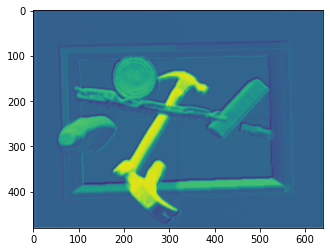

In [32]:
with torch.no_grad():
    output = model_image_prediction.forward(whole_image_training_set[20][0].unsqueeze(0).to(device)).cpu().numpy()[0]
    grasp_score = output[0,:,:]
    plt.imshow(grasp_score)

## Written responses

### Written response for Problem 1.B

I am using color, depth, color gradient and depth gradient in the dataset. The model I am using is pca with mlp regressor. In addition, use the RandomizedSearchCV model selection technique to melp me get the hidden_layer_sizes hyper parameter. The founded hidden_layer_sizes is 103 and the n_components for pca is 14. 

The average score is 0.424 and the score using pca and linear regression is 0.675. The score from my algorithm is 0.796, which is higher than either scores. 

### Written response for Problem 1.C

![Prob 1C](predictions/image_0000.png)

### Written response for Problem 2.A

For the two layer model, the training loss and training score RMSE first increase, than decrease and become stable. For the cnn model, the traiing loss and training score RMSE didn't increase as much as that of two layer model and remain stable quickly. In addition, the final testing loss and RMSE from CNN is slightly lower. 

### Written response for Problem 2.B

I add a little bit of transform to both the color and depth channel. I notice that the final testing loss and RMSE for both two layer net and CNN increase a little bit. 

### Written response for Problem 3

The final result I get seems to be improved a lot compared with result in Problem 2. I didn't do anything to improve the result. However, I think the result can be further improved by having more training image.